# **MOUNTING DRIVE**

In [1]:
#mounting drive for data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Installing required Libraries**

In [2]:
# installing sentence Splitter Libraries
! pip install sentence-splitter

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.0/45.0 kB 1.8 MB/s eta 0:00:00


In [3]:
# installing transformers Library from hugging face
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.1/311.1 kB 40.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 44.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 55.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 32.5 MB/s eta 0:00:00


In [4]:
# installing SentencePiece Library
!pip install SentencePiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 6.0 MB/s eta 0:00:00


In [5]:
# installing Colorama Library
!pip install colorama

# **IMPORTING LIBRARIES**

In [6]:
#importing required Libraries
import json
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder

import pickle

# https://huggingface.co/tuner007/pegasus_paraphrase

#import torch
from joblib import Parallel, delayed
import joblib
import os
import json

# import colorama
# colorama.init()
# from colorama import Fore, Style, Back

# import random

# from difflib import SequenceMatcher

# **DEFINING MODELS**

In [7]:
enableSequenceLearning = False
#Generate all occurances of a string list
from itertools import permutations
from sklearn.model_selection import train_test_split
from keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import pandas as pd

def generate_occurrences(string_list):
    occurrences = list(permutations(string_list))
    #converting list of tuples to a list of lists
    dataList = []
    for occurance in occurrences:
      dataList.append(list(occurance))
    #print(dataList)
    return dataList

#HABBIT TRACING ML MODEL
def set_habit_tracer_model():
    #get disease habit data
    with open('/content/drive/MyDrive/skin_alert/implementations/habitual_processing/data/disease_habits.json') as file:
      data = json.load(file)

    #definng variables
    input_data_habits = []
    input_data_labels = []

    labels = []
    disease_habit_occurance_counts = []

    #defining default constants
    vocab_size = 10000
    embedding_dim = 8
    max_len = 15
    oov_token = "<OOV>"
    epochs = 500
    test_size = 0.2

    #getting data from json
    for disease_habits in data['disease-habit']:
      # print(disease_habits['habits'])
      if enableSequenceLearning == True:
        epochs = 10
        ocurancesList =generate_occurrences(disease_habits['habits'])

        for occurance in ocurancesList:
          input_data_habits.append(occurance)
          input_data_labels.append(disease_habits['name'])
        disease_habit_occurance_counts.append(len(ocurancesList))
      else :
        input_data_habits.append(disease_habits['habits'])
        input_data_labels.append(disease_habits['name'])
        disease_habit_occurance_counts.append(len(disease_habits['habits']))


      if disease_habits['name'] not in labels:
        labels.append(disease_habits['name'])

    # Create a bar chart to show input data

    # for item in disease_habit_occurance_counts:
    #   print(item)
    # print(len(labels))
    # print(len(disease_habit_occurance_counts))

    plt.figure(figsize=(8, 6))
    plt.bar(labels, disease_habit_occurance_counts)
    plt.xlabel('Diseases')
    plt.ylabel('Habits')
    plt.title('Disease Habitual Actions')
     # Rotate the x-axis labels
    plt.xticks(rotation=45)
    plt.show()

    # Split the input data into training and test sets
    training_habits, testing_habits, training_labels, testing_labels = train_test_split(input_data_habits, input_data_labels, test_size=test_size, random_state=42)
    training_habits = input_data_habits
    training_labels = input_data_labels
    # max_len = len(training_labels)


    #counting no of classes
    num_classes = len(labels)

    #encode class labels
    lbl_encoder = LabelEncoder()
    print(training_labels)
    lbl_encoder.fit(training_labels)
    training_labels = lbl_encoder.transform(training_labels)

    #tokenizing Traning Behaviors
    tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
    tokenizer.fit_on_texts(training_habits)
    word_index = tokenizer.word_index
    sequences = tokenizer.texts_to_sequences(training_habits)
    padded_sequences = pad_sequences(sequences, truncating='post', maxlen=max_len)


    model = Sequential()

    model.add(Embedding(vocab_size, embedding_dim, input_length=max_len))
    model.add(GlobalAveragePooling1D())
    model.add(Dense(16, activation='relu'))
    model.add(Dense(16, activation='relu'))
    # model.add(Dense(16, activation='relu', kernel_regularizer=l2(0.5)))
    # model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])

    model.summary()

    trainHistory = model.fit(padded_sequences, np.array(training_labels), epochs=epochs)

    # to save the trained model
    model._name = "habit_tracer_model"
    model.save("/content/drive/MyDrive/skin_alert/implementations/habitual_processing/model/disease-tracer-model")

    # to save the fitted tokenizer
    with open('/content/drive/MyDrive/skin_alert/implementations/habitual_processing/model/disease-tracer-model/prediction-tokenizer.pickle', 'wb') as handle:
      pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

    # to save the fitted label encoder
    with open('/content/drive/MyDrive/skin_alert/implementations/habitual_processing/model/disease-tracer-model/prediction-label_encoder.pickle', 'wb') as ecn_file:
      pickle.dump(lbl_encoder, ecn_file, protocol=pickle.HIGHEST_PROTOCOL)

    # Define the window size for the moving average
    window_size = 6

    # Calculate the moving average using pandas
    accuracy_smoothed = pd.Series(trainHistory.history['accuracy']).rolling(window=window_size, min_periods=1).mean()


    fig = plt.figure(figsize=(14,7))
    plt.plot(trainHistory.history['loss'], label='Training Loss')
    plt.legend()
    plt.show()
    plt.savefig('LossVal_loss')

    # plot the accuracy
    fig = plt.figure(figsize=(14,7))
    plt.plot(accuracy_smoothed, label='Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    plt.savefig('AccVal_acc')


    # testing_padded_sequences = tokenizer.texts_to_sequences(testing_habits)
    # testing_padded_sequences = pad_sequences(testing_padded_sequences, maxlen=max_len)

    # # Evaluate the model on the test data
    # loss, accuracy = model.evaluate(testing_padded_sequences, testing_labels)

    # print("Test Loss:", loss)
    # # print("Test Accuracy:" + str(int(str(accuracy)) * 100 ) + " %" )
    # print("Test Accuracy: {:.2f}%".format(accuracy * 100))

# **EXECUTE BUILD MODELS**

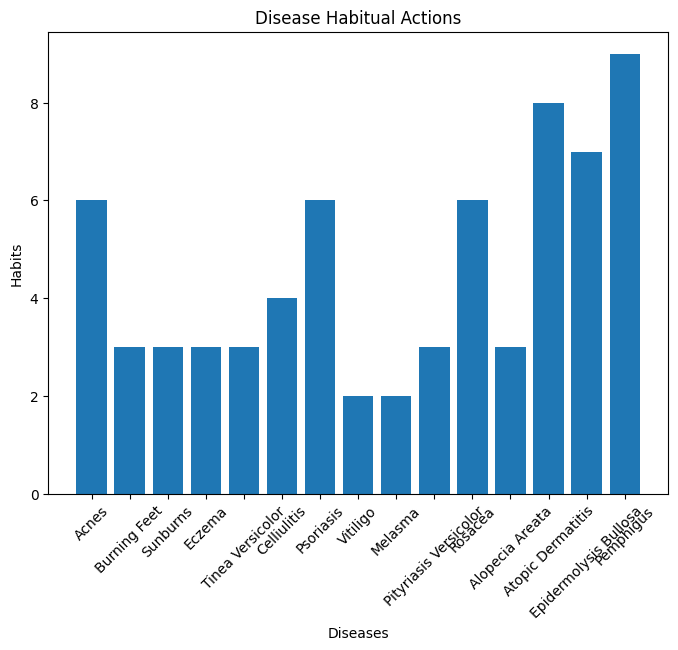

['Acnes', 'Burning Feet', 'Sunburns', 'Eczema', 'Tinea Versicolor', 'Celliulitis', 'Psoriasis', 'Vitiligo', 'Melasma', 'Pityriasis Versicolor', 'Rosacea', 'Alopecia Areata', 'Atopic Dermatitis', 'Epidermolysis Bullosa', 'Pemphigus']
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 15, 8)             80000     
                                                                 
 global_average_pooling1d_1  (None, 8)                 0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_3 (Dense)             (None, 16)                144       
                                                                 
 dense_4 (Dense)             (None, 16)                272       
                                                                 
 dense_5 (Dense)   

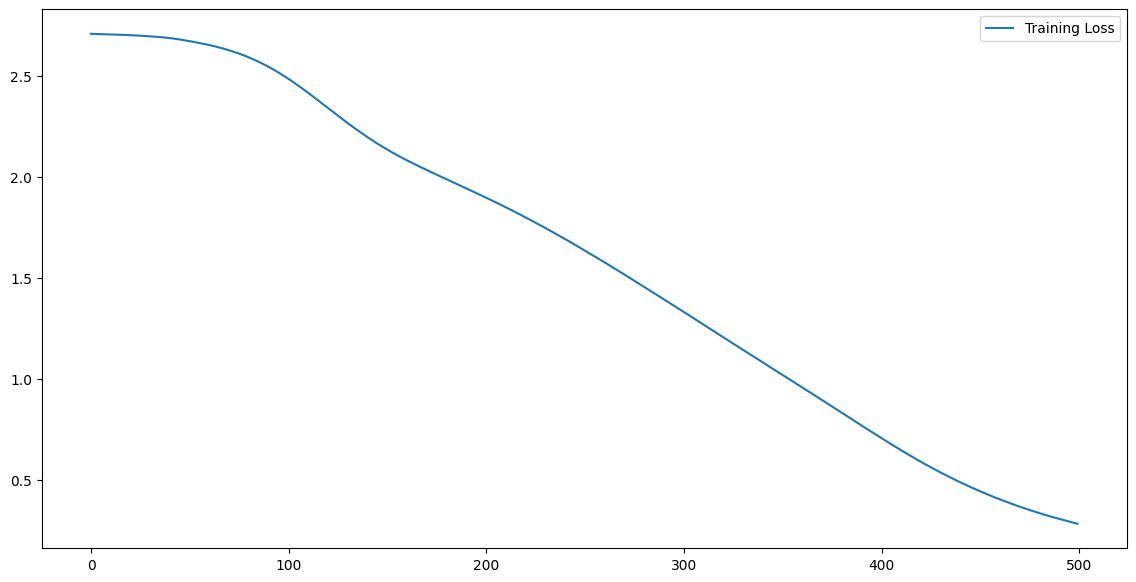

<Figure size 640x480 with 0 Axes>

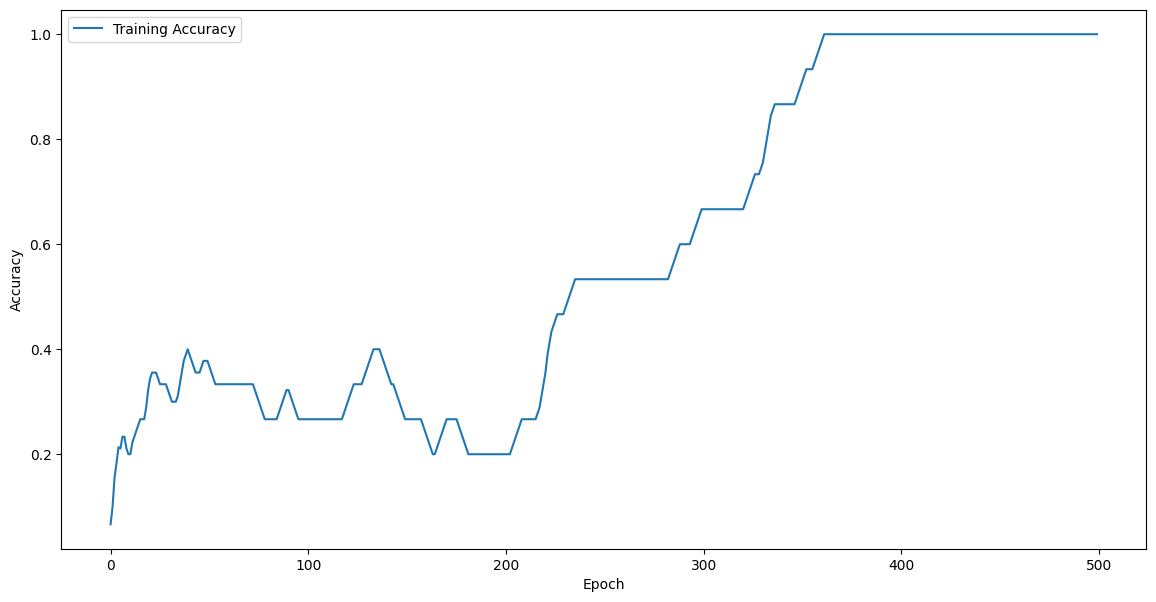

<Figure size 640x480 with 0 Axes>

In [9]:
#executing habit tracer Model
set_habit_tracer_model()